In [5]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from PIL import Image
import matplotlib.image as mpimg
from io import BytesIO

In [60]:
visited = set()
# creating a set to determine which URLs we've already visited
# creating an extract favicon function to return the icon href
def extract_favicon(url):
    try:
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.content, 'html.parser')
        for link in soup.find_all('link', rel=lambda v: v and 'icon' in v):
            icon_href=link.get('href')
            if icon_href:
                if not icon_href.startswith('http'):
                    parsed_uri = urlparse(url)
                    base = '{uri.scheme}://{uri.netloc}'.format(uri=parsed_uri)
                    icon_href = base + icon_href if icon_href.startswith('/') else base + '/' + icon_href
                try:
                    # Attempt to open the image to ensure it's valid
                    image_response = requests.get(icon_href)
                    Image.open(BytesIO(image_response.content)).verify()
                except (IOError, UnidentifiedImageError):
                    # If an error occurs, print the error and continue without returning the invalid favicon
                    print(f"Invalid favicon at {icon_href}")
                    continue
                return icon_href
        return None
    except Exception as e:
        print(f"Failed to extract favicon from {url}: {e}")
        return None

In [61]:
# now we modify the function so that we can recursively crawl through links on the initial page

#recursive function taking in these 4 params
def crawl(url, depth, tree, parent=None):
    if depth == 0 or url in visited:
            return
    visited.add(url)
    favicon = extract_favicon(url)
    tree[url] = {'favicon': favicon, 'children': []}
    # populating the dictionary 
    if parent:
        tree[parent]['children'].append(url)
    # using the requests library to retrieve the URL content + processing it
    try: 
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.content, 'html.parser')
        for link in soup.find_all('a'):
            href = link.get('href')
            if href and href.startswith('http'):
                crawl(href, depth - 1, tree, parent=url)
    except Exception as e:
        print(f"Failed to crawl {url}: {e}")

In [62]:
def create_tree_diagram(tree):
    # using the nx library to create a graph
    G = nx.DiGraph()
    # iterating over the tree and adding a node and its edge to the graph
    for node, data in tree.items():
        G.add_node(node)
        for child in data['children']:
            G.add_edge(node,child)
    pos = nx.spring_layout(G)
    fig, ax = plt.subplots(figsize=(12,12))

    nx.draw(G, pos, ax=ax, with_labels=True, node_size=2000, node_color='skyblue', font_size=10)

    for node, data in tree.items():
        if data['favicon']:
            image = Image.open(BytesIO(requests.get(data['favicon']).content))
            image = image.convert("RGBA")
            image.thumbnail((32,32))
            im = OffsetImage(image, zoom=1)
            im.image.axes = ax

            ab = AnnotationBbox(im, pos[node], xybox=(0.,-20.), frameon=False, boxcoords="offset points", pad=0)
            ax.add_artist(ab)

    plt.title("Web Crawler Tree Diagram")
    plt.show()


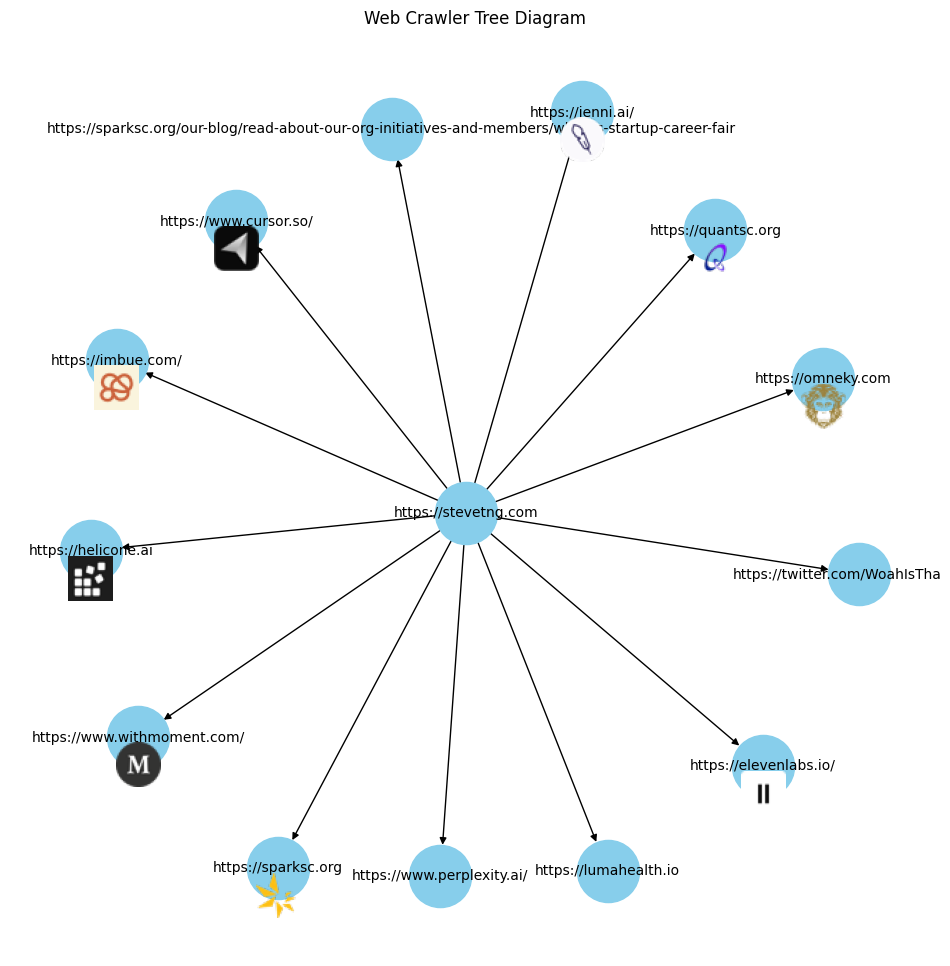

In [68]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

visited = set()
tree = {}
crawl('https://stevetng.com', 2, tree)
create_tree_diagram(tree)
